In [15]:
# Eric's modification
import os
import torch
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from datetime import datetime
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
from torch.utils.data import TensorDataset, DataLoader, Subset
#import torchvision
from os import path

from src.utils import *
from src.models import *
from src.methods import *

data_path = os.path.join(os.getcwd(), 'project_data/')
print(data_path)

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

2024-03-15 22:46:10
/home/banyh2000/ECE247-Group-Project/project_data/
cuda


In [16]:
X_test = np.load(data_path+"X_test.npy")
y_test = np.load(data_path+"y_test.npy")
person_train_valid = np.load(data_path+"person_train_valid.npy")
X_train_valid = np.load(data_path+"X_train_valid.npy")
y_train_valid = np.load(data_path+"y_train_valid.npy")
person_test = np.load(data_path+"person_test.npy")
#:\Users\pluto\Desktop\2024_winter\ECE_147\final_project\ECE247-Group-Project\src\project_data\y_test.npy

In [17]:
X_test = np.load(data_path + "X_test.npy")
y_test = np.load(data_path + "y_test.npy") - 769
person_train_valid = np.load(data_path + "person_train_valid.npy")
X_train_valid = np.load(data_path + "X_train_valid.npy")
y_train_valid = np.load(data_path + "y_train_valid.npy") - 769
person_test = np.load(data_path + "person_test.npy")

In [18]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [19]:
X_train_valid = X_train_valid[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [20]:
X_train_valid = torch.from_numpy(X_train_valid).float()
y_train_valid = torch.from_numpy(y_train_valid).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_valid_dataset = TensorDataset(X_train_valid, y_train_valid)
test_dataset = TensorDataset(X_test, y_test)

# Splitting the dataset into train and valid sets
num_train = int(0.8 * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train
train_indices, valid_indices = random_split(range(len(train_valid_dataset)), [num_train, num_valid])

train_dataset = Subset(train_valid_dataset, train_indices)
valid_dataset = Subset(train_valid_dataset, valid_indices)


# Wrapping datasets with GaussianNoisyDataset
train_dataset_noisy = GaussianNoisyDataset(train_dataset, mean=0., std=1.)
valid_dataset_noisy = GaussianNoisyDataset(valid_dataset, mean=0., std=1.)
test_dataset_noisy = GaussianNoisyDataset(test_dataset, mean=0., std=1.)

batch_size = 32
train_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_noisy, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_noisy, batch_size=batch_size, shuffle=False)

print('Training/Valid data shape:', X_train_valid.shape)
print('Test data shape:', X_test.shape)

Training/Valid data shape: torch.Size([2115, 1, 22, 1000])
Test data shape: torch.Size([443, 1, 22, 1000])


In [7]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/ConvNet+{time}')
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

train(model, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=50)

test_accuracy = evaluate(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

 20%|██        | 10/50 [00:14<00:54,  1.37s/it]

Epoch [10/50], Loss: 0.5230, Validation Accuracy: 52.48%


 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

Epoch [20/50], Loss: 0.1966, Validation Accuracy: 55.79%


 54%|█████▍    | 27/50 [00:38<00:32,  1.43s/it]

Early stopping!
Test Accuracy: 55.30%


In [ ]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/LSTM+{time}')
lstm = LSTMModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

lstm = lstm.to(device)
train(lstm, train_loader, valid_loader, criterion, optimizer, writer=writer, device=device)

test_accuracy = evaluate(lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/ViT+{time}')
vit = ViT(patch_size=(22, 1), num_classes=4, dim=64, num_head=8, num_layers = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit.parameters(), lr=0.01, momentum=0.9)

vit = vit.to(device)
train(vit, train_loader, valid_loader, criterion, optimizer, writer= writer, device=device, epochs=200)

test_accuracy = evaluate(vit, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

In [23]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/EEG+{time}')
eegn = EEGNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eegn.parameters(), lr = 0.001, betas=(0.9, 0.99),  eps=1e-7, weight_decay=0.0005)

eegn = eegn.to(device)
train(eegn, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=200)

test_accuracy = evaluate(eegn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  5%|▌         | 10/200 [00:12<04:03,  1.28s/it]

Epoch [10/200], Loss: 0.8392, Validation Accuracy: 62.65%


 10%|█         | 20/200 [00:25<03:59,  1.33s/it]

Epoch [20/200], Loss: 0.6932, Validation Accuracy: 66.67%


 15%|█▌        | 30/200 [00:39<03:51,  1.36s/it]

Epoch [30/200], Loss: 0.6344, Validation Accuracy: 69.03%


 20%|██        | 40/200 [00:52<03:37,  1.36s/it]

Epoch [40/200], Loss: 0.5732, Validation Accuracy: 69.74%


 25%|██▌       | 50/200 [01:06<03:24,  1.36s/it]

Epoch [50/200], Loss: 0.5532, Validation Accuracy: 74.70%


 30%|███       | 60/200 [01:19<03:00,  1.29s/it]

Epoch [60/200], Loss: 0.5150, Validation Accuracy: 70.69%


 34%|███▍      | 69/200 [01:32<02:55,  1.34s/it]

Epoch [70/200], Loss: 0.4888, Validation Accuracy: 72.10%
Early stopping!
Test Accuracy: 70.43%


In [ ]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/CNN_LSTM+{time}')
cnn_lstm = CNN_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6)

cnn_lstm = cnn_lstm.to(device)
train(cnn_lstm, train_loader, valid_loader, criterion, optimizer, writer=writer, device=device, epochs=50)

test_accuracy = evaluate(cnn_lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'runs/UltimateConvNet+{time}')
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=200)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

In [1]:
import ray
from ray import tune
from ray import train as raytrain
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from src.methods_ray import train_ray_Ultimateconfig
from ray.tune.search.bayesopt import BayesOptSearch
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min', max_t= 250)
reporter = CLIReporter(metric_columns=['loss'])
bayesopt = BayesOptSearch(
    metric='loss',
    mode='min',
)

# config = {
#     'weight_decay': tune.loguniform(1e-4, 1e-3),
# }

config = {
    'lr': tune.loguniform(3e-4, 3e-3),
}


analysis = tune.run(
    train_ray_Ultimateconfig,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=20,
    search_alg=bayesopt,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

2024-03-15 19:02:48,814	INFO worker.py:1724 -- Started a local Ray instance.
2024-03-15 19:02:49,773	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-03-15 19:02:49,782	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


== Status ==
Current time: 2024-03-15 19:02:49 (running for 00:00:00.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 1/20 (1 PENDING)
+-----------------------------------+----------+-------+------------+
| Trial name                        | status   | loc   |         lr |
|-----------------------------------+----------+-------+------------|
| train_ray_Ultimateconfig_7243f83f | PENDING  |       | 0.00131126 |
+-----------------------------------+----------+-------+------------+


== Status ==
Current time: 2024-03-15 19:02:55 (running for 00:00:05.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerat

Trial name,loss
train_ray_Ultimateconfig_05d68c71,1.02706
train_ray_Ultimateconfig_26b81b79,1.33614
train_ray_Ultimateconfig_4cdcb38f,1.22342
train_ray_Ultimateconfig_51fe713c,1.34601
train_ray_Ultimateconfig_7243f83f,0.818448
train_ray_Ultimateconfig_8e1c0e56,1.36311
train_ray_Ultimateconfig_98bf61de,1.32611
train_ray_Ultimateconfig_b136d8b9,0.771988
train_ray_Ultimateconfig_d3eef1b1,1.05619
train_ray_Ultimateconfig_eefb432c,1.22615


== Status ==
Current time: 2024-03-15 19:03:00 (running for 00:00:10.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -1.319820780703362
Logical resource usage: 0/40 CPUs, 3.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 3/20 (3 RUNNING)
+-----------------------------------+----------+----------------------+------------+---------+
| Trial name                        | status   | loc                  |         lr |    loss |
|-----------------------------------+----------+----------------------+------------+---------|
| train_ray_Ultimateconfig_7243f83f | RUNNING  | 131.179.88.212:26292 | 0.00131126 | 1.2472  |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING  | 131.179.88.212:26367 | 0.00286693 | 1.30625 |
| train_ray_Ultimateconfig_26b81b79 | RUNNING  | 131.179.88.212:26488 | 0.00227638 |         |
+-----------------------

2024-03-15 19:03:06,964	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0007211852049077471}.


== Status ==
Current time: 2024-03-15 19:03:10 (running for 00:00:20.37)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.1896210377661611 | Iter 1.000: -1.3221598113964073
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 6/20 (1 PENDING, 3 RUNNING, 2 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+---------+
| Trial name                        | status     | loc                  |          lr |    loss |
|-----------------------------------+------------+----------------------+-------------+---------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 1.09068 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 1.10543 |
| train_ray_Ultimateconfig_eefb432c | RUNNING    | 131.179.88.2

2024-03-15 19:03:13,934	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019230105317066637}.


== Status ==
Current time: 2024-03-15 19:03:15 (running for 00:00:25.41)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.19728222595039 | Iter 1.000: -1.3256545510697872
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 8/20 (1 PENDING, 3 RUNNING, 4 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+---------+
| Trial name                        | status     | loc                  |          lr |    loss |
|-----------------------------------+------------+----------------------+-------------+---------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 1.06424 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 1.05197 |
| train_ray_Ultimateconfig_05d68c71 | RUNNING    | 131.179.88.212

2024-03-15 19:03:25,196	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001088790551045089}.


== Status ==
Current time: 2024-03-15 19:03:25 (running for 00:00:35.50)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: -1.0220827925994325 | Iter 4.000: -1.1834220766457542 | Iter 1.000: -1.314936928997085
Logical resource usage: 0/40 CPUs, 5.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (5 RUNNING, 5 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 1.08588  |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.936063 |
| train_ray_Ultimateconfig_05d68c71 | RUNNING    | 131

2024-03-15 19:03:26,326	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001122457176768101}.
2024-03-15 19:03:27,447	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0007991070299189231}.
2024-03-15 19:03:27,506	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0029178784949643083}.
2024-03-15 19:03:28,776	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0006804954074318591}.
2024-03-15 19:03:29,046	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0023850608771009752}.
2024-03-15 19:03:29,148	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008365323401422656}.
2024-03-15 19:03:29,450	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0022085148283885665}.
2024-03-15 19:03:29,753	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0004999205596820439}.
2024-03-15 19:03:30,261	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr':

== Status ==
Current time: 2024-03-15 19:03:30 (running for 00:00:40.57)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: -1.0220827925994325 | Iter 4.000: -1.1884235941208283 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (4 RUNNING, 6 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.948922 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.936224 |
| train_ray_Ultimateconfig_05d68c71 | RUNNING    | 13

2024-03-15 19:03:31,202	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0023816113858773145}.
2024-03-15 19:03:31,777	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002018308110412207}.
2024-03-15 19:03:32,787	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0024819250248239257}.
2024-03-15 19:03:33,089	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002469914607627609}.
2024-03-15 19:03:33,191	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008037391589922967}.
2024-03-15 19:03:33,449	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002480088418942969}.
2024-03-15 19:03:33,551	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002719446509793432}.
2024-03-15 19:03:33,807	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009154249388632425}.
2024-03-15 19:03:33,823	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.

== Status ==
Current time: 2024-03-15 19:03:35 (running for 00:00:45.63)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: -1.0220827925994325 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (4 RUNNING, 6 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.944265 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.90031  |
| train_ray_Ultimateconfig_05d68c71 | RUNNING    | 131

2024-03-15 19:03:35,634	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019458237017457214}.
2024-03-15 19:03:35,950	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002752317892109965}.
2024-03-15 19:03:36,258	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002961256226098622}.
2024-03-15 19:03:36,360	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009535492330810511}.
2024-03-15 19:03:36,592	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002266184141252021}.
2024-03-15 19:03:36,693	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012930144583419836}.
2024-03-15 19:03:36,794	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0020072257426026648}.
2024-03-15 19:03:36,896	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0020105302190544156}.
2024-03-15 19:03:37,098	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0

== Status ==
Current time: 2024-03-15 19:03:40 (running for 00:00:50.72)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: -1.0184233182288231 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 3.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (3 RUNNING, 7 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.91924  |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.865498 |
| train_ray_Ultimateconfig_d3eef1b1 | RUNNING    | 131

2024-03-15 19:03:40,723	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002726096309023114}.
2024-03-15 19:03:40,824	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019373584610808928}.
2024-03-15 19:03:40,926	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0003248320393649}.
2024-03-15 19:03:41,088	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002091454776591751}.
2024-03-15 19:03:41,172	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0003136662763847904}.
2024-03-15 19:03:41,345	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0017815812312897824}.
2024-03-15 19:03:41,446	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002168117033770272}.
2024-03-15 19:03:41,648	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009055271355435115}.
2024-03-15 19:03:41,850	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-15 19:03:45 (running for 00:00:55.76)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: -1.0184233182288231 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 3.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (3 RUNNING, 7 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.901793 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.866302 |
| train_ray_Ultimateconfig_d3eef1b1 | RUNNING    | 131

2024-03-15 19:03:45,926	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0006782268411386148}.
2024-03-15 19:03:46,028	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0016994900613820892}.
2024-03-15 19:03:46,129	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0026689072942054797}.
2024-03-15 19:03:46,282	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0021819425006872235}.
2024-03-15 19:03:46,284	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002196707026765195}.
2024-03-15 19:03:46,385	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012706261082933389}.
2024-03-15 19:03:46,486	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001092697979514132}.
2024-03-15 19:03:46,688	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0024873061656337883}.
2024-03-15 19:03:46,789	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 

== Status ==
Current time: 2024-03-15 19:03:50 (running for 00:01:00.86)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.0227410819020397 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.895568 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.831494 |
| train_ray_Ultimateconfig_26b81b79 | TERMINATED | 131

2024-03-15 19:03:50,693	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002179130356452985}.
2024-03-15 19:03:50,810	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0007678946641912837}.
2024-03-15 19:03:50,911	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0007223800152119323}.
2024-03-15 19:03:51,012	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009756558250444073}.
2024-03-15 19:03:51,113	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0017829119947065254}.
2024-03-15 19:03:51,214	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0022294089912901684}.
2024-03-15 19:03:51,315	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0020825329171378745}.
2024-03-15 19:03:51,417	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010558215217540458}.
2024-03-15 19:03:51,518	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr':

== Status ==
Current time: 2024-03-15 19:03:55 (running for 00:01:05.92)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.0227410819020397 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.925898 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.851245 |
| train_ray_Ultimateconfig_26b81b79 | TERMINATED | 131

2024-03-15 19:03:56,017	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0004922093508426183}.
2024-03-15 19:03:56,118	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0011612342017931555}.
2024-03-15 19:03:56,320	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0003628342264867298}.
2024-03-15 19:03:56,421	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0024990649029901267}.
2024-03-15 19:03:56,522	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010610078918881797}.
2024-03-15 19:03:56,570	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.000619045034578472}.
2024-03-15 19:03:56,604	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0021811903464832067}.
2024-03-15 19:03:56,705	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001998145686305687}.
2024-03-15 19:03:56,806	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 

== Status ==
Current time: 2024-03-15 19:04:00 (running for 00:01:10.95)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.0227410819020397 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | RUNNING    | 131.179.88.212:26292 | 0.00131126  | 0.903116 |
| train_ray_Ultimateconfig_b136d8b9 | RUNNING    | 131.179.88.212:26367 | 0.00286693  | 0.830531 |
| train_ray_Ultimateconfig_26b81b79 | TERMINATED | 131

2024-03-15 19:06:57,976	INFO tune.py:1042 -- Total run time: 248.20 seconds (248.17 seconds for the tuning loop).


== Status ==
Current time: 2024-03-15 19:06:57 (running for 00:04:08.18)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8428914934467199 | Iter 16.000: -1.0227410819020397 | Iter 4.000: -1.184861878624481 | Iter 1.000: -1.3111223019043041
Logical resource usage: 0/40 CPUs, 1.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-15_19-02-49
Number of trials: 10/20 (10 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_7243f83f | TERMINATED | 131.179.88.212:26292 | 0.00131126  | 0.818448 |
| train_ray_Ultimateconfig_b136d8b9 | TERMINATED | 131.179.88.212:26367 | 0.00286693  | 0.771988 |
| train_ray_Ultimateconfig_26b81b79 | TERMINATED 

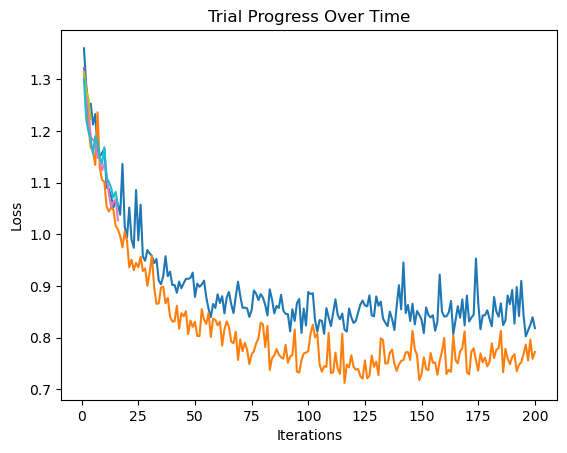

In [3]:
dfs = analysis.trial_dataframes
import matplotlib.pyplot as plt

for d in dfs.values():
    # TODO: Plot the results
    plt.plot(d['training_iteration'], d['loss'], label=d['config/lr'][0])

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Trial Progress Over Time')
plt.show()

In [16]:
# run with best hyperparameters
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") 
writer = SummaryWriter(f'runs/UltimateConvNet+{time}')

ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = best_config['lr'], betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0004370)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, writer = writer, device=device, epochs=200,patience=40)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  5%|▌         | 10/200 [00:13<04:10,  1.32s/it]

Epoch [10/200], Loss: 1.1334, Validation Accuracy: 46.34%


 10%|█         | 20/200 [00:26<03:56,  1.31s/it]

Epoch [20/200], Loss: 0.9817, Validation Accuracy: 54.61%


 15%|█▌        | 30/200 [00:39<03:46,  1.33s/it]

Epoch [30/200], Loss: 0.9019, Validation Accuracy: 57.45%


 20%|██        | 40/200 [00:53<03:51,  1.44s/it]

Epoch [40/200], Loss: 0.7927, Validation Accuracy: 63.12%


 25%|██▌       | 50/200 [01:06<03:18,  1.32s/it]

Epoch [50/200], Loss: 0.7662, Validation Accuracy: 62.65%


 30%|███       | 60/200 [01:19<03:07,  1.34s/it]

Epoch [60/200], Loss: 0.7229, Validation Accuracy: 67.38%


 35%|███▌      | 70/200 [01:33<02:51,  1.32s/it]

Epoch [70/200], Loss: 0.7320, Validation Accuracy: 67.85%


 40%|████      | 80/200 [01:46<02:37,  1.31s/it]

Epoch [80/200], Loss: 0.6543, Validation Accuracy: 66.90%


 45%|████▌     | 90/200 [01:59<02:24,  1.31s/it]

Epoch [90/200], Loss: 0.6675, Validation Accuracy: 66.90%


 50%|█████     | 100/200 [02:12<02:10,  1.31s/it]

Epoch [100/200], Loss: 0.6339, Validation Accuracy: 66.67%


 55%|█████▌    | 110/200 [02:26<02:05,  1.39s/it]

Epoch [110/200], Loss: 0.6471, Validation Accuracy: 65.96%


 60%|██████    | 120/200 [02:39<01:45,  1.31s/it]

Epoch [120/200], Loss: 0.6007, Validation Accuracy: 69.98%


 65%|██████▌   | 130/200 [02:52<01:32,  1.32s/it]

Epoch [130/200], Loss: 0.6391, Validation Accuracy: 69.50%


 70%|███████   | 140/200 [03:05<01:18,  1.30s/it]

Epoch [140/200], Loss: 0.5917, Validation Accuracy: 68.09%


 75%|███████▌  | 150/200 [03:18<01:04,  1.30s/it]

Epoch [150/200], Loss: 0.6017, Validation Accuracy: 65.01%


 80%|████████  | 160/200 [03:32<00:55,  1.38s/it]

Epoch [160/200], Loss: 0.5985, Validation Accuracy: 66.19%


 85%|████████▌ | 170/200 [03:45<00:39,  1.31s/it]

Epoch [170/200], Loss: 0.6077, Validation Accuracy: 68.32%


 89%|████████▉ | 178/200 [03:57<00:29,  1.33s/it]

Early stopping!
Test Accuracy: 69.53%
